In [1]:
import pandas as pd, numpy as np
import os, json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torch_data
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.manifold import TSNE
import umap
from datetime import datetime, timedelta
os.getcwd()
# Add parent path for import
from forecast_dataloader import ForecastDataset, de_normalized
pd.set_option('display.max_columns', 50)

/home/users/arash/anaconda3/envs/pyg/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/users/arash/anaconda3/envs/pyg/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/users/arash/anaconda3/envs/pyg/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but

In [2]:
TRAIN_RATIO = 0.7
VALID_RATIO = 0.2
TEST_RATIO = 1 - (TRAIN_RATIO + VALID_RATIO)

WINDOW_SIZE = 24
HORIZON = 6
NORM_METHOD = 'z_score'
DATASET = 'New York'
START_POI = 0
END_POI = 40
BATCH_SIZE = 1
START_DATE = '2018-12-31'

TOTAL_DAYS = 400

In [3]:
date_format = r'%Y-%m-%d'
start_time = datetime.strptime(START_DATE, date_format)
end_time = start_time + timedelta(days=TOTAL_DAYS)

train_days = int(TRAIN_RATIO * TOTAL_DAYS)
valid_days = int(TOTAL_DAYS * VALID_RATIO)
test_days = TOTAL_DAYS - train_days - valid_days

time_span = pd.date_range(start_time, end_time, freq='1H', closed='left').to_numpy()
valid_dates = time_span[train_days*24 + WINDOW_SIZE:(train_days + valid_days)*24 - HORIZON + 1]
test_dates = time_span[(train_days + valid_days)*24 + WINDOW_SIZE: - HORIZON + 1]

/tmp/ipykernel_22965/2841897662.py:9: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  time_span = pd.date_range(start_time, end_time, freq='1H', closed='left').to_numpy()


In [4]:
os.chdir('/home/users/arash/NGA Project/POI_paper/busyness_graph_adj_interpretation/bysgnn_orig')
df = pd.read_pickle(f'cache_data/data-{START_POI}-{END_POI}-{TOTAL_DAYS}-{DATASET}.pkl')
# df = df.iloc[START_POI:END_POI]

data = pd.DataFrame(df["visits_by_each_hour"].to_list()).T

# split data
days = int(data.shape[0] / 24)

train_days = int(TRAIN_RATIO * days)
valid_days = int(days*VALID_RATIO)
test_days = days-train_days-valid_days

train_data = data[:train_days*24]
valid_data = data[train_days*24:(train_days + valid_days)*24]
test_data = data[(train_days + valid_days)*24:(train_days + valid_days+test_days)*24]

with open(os.path.join(f'output/{DATASET}/train_{START_POI}_{END_POI}', 'norm_stat.json'),'r') as f:
    normalize_statistic = json.load(f)


test_set = ForecastDataset(test_data, window_size=WINDOW_SIZE, 
                            horizon=HORIZON,
                            normalize_method=NORM_METHOD, 
                            norm_statistic=normalize_statistic)

test_loader = torch_data.DataLoader(test_set, batch_size=BATCH_SIZE, drop_last=False,
                                    shuffle=False, num_workers=0)

valid_set = ForecastDataset(valid_data, window_size=WINDOW_SIZE, horizon=HORIZON,
                            normalize_method=NORM_METHOD, norm_statistic=normalize_statistic)
valid_loader = torch_data.DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
model_orig_adj = torch.load(f'output/{DATASET}/train_{START_POI}_{END_POI}/39_stemgnn.pt')
os.chdir('/home/users/arash/NGA Project/POI_paper/busyness_graph_adj_interpretation/attention_adj')
model_att_adj = torch.load(f'output/{DATASET}/train_{START_POI}_{END_POI}/39_stemgnn.pt')
os.chdir('/home/users/arash/NGA Project/POI_paper/busyness_graph_adj_interpretation/dist_adj')
model_dist_adj = torch.load(f'output/{DATASET}/train_{START_POI}_{END_POI}/39_stemgnn.pt')
os.chdir('/home/users/arash/NGA Project/POI_paper/busyness_graph_adj_interpretation/semantics_adj')
model_semantics_adj = torch.load(f'output/{DATASET}/train_{START_POI}_{END_POI}/39_stemgnn.pt')
os.chdir('/home/users/arash/NGA Project/POI_paper/busyness_graph_adj_interpretation/')

In [5]:
def get_sample_by_datetime(datetime_str, test_dates, test_loader):
    datetime_input = datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')
    datetime_input_np = np.datetime64(datetime_input)

    for i, data in enumerate(test_loader):
        if test_dates[i] == datetime_input_np:
            return data
    raise ValueError("Datetime not found in test_dates array.")

### Wednesday, Jan 22, 2020 10:00:00 AM (Lunch time in weekday)

In [6]:
x, y = get_sample_by_datetime('2020-01-22 10:00:00', test_dates, test_loader)
x.shape, y.shape

(torch.Size([1, 24, 50]), torch.Size([1, 6, 50]))

In [7]:
model_orig_adj.eval()
model_att_adj.eval()
model_dist_adj.eval()
model_semantics_adj.eval()
with torch.no_grad():
    forecast_result_orig_adj, _, (adj_mat_thresholded_orig_adj, adj_mat_unthresholded_orig_adj, 
                                  embed_att_orig_adj, dist_adj_orig_adj, mhead_att_mat_orig_adj), gnn_embeddings_orig_adj = model_orig_adj(x)
    forecast_result_att_adj, _, (adj_mat_thresholded_att_adj, adj_mat_unthresholded_att_adj, 
                                    embed_att_att_adj, dist_adj_att_adj, mhead_att_mat_att_adj), gnn_embeddings_att_adj = model_att_adj(x)
    forecast_result_dist_adj, _, (adj_mat_thresholded_dist_adj, adj_mat_unthresholded_dist_adj,
                                    embed_att_dist_adj, dist_adj_dist_adj, mhead_att_mat_dist_adj), gnn_embeddings_dist_adj = model_dist_adj(x)
    forecast_result_semantics_adj, _, (adj_mat_thresholded_semantics_adj, adj_mat_unthresholded_semantics_adj,
                                    embed_att_semantics_adj, dist_adj_semantics_adj, mhead_att_mat_semantics_adj), gnn_embeddings_semantics_adj = model_semantics_adj(x)

In [8]:
# convert all gnn embeddings to numpy
gnn_embeddings_orig_adj = gnn_embeddings_orig_adj.cpu().numpy().squeeze(0)
gnn_embeddings_att_adj = gnn_embeddings_att_adj.cpu().numpy().squeeze(0)
gnn_embeddings_dist_adj = gnn_embeddings_dist_adj.cpu().numpy().squeeze(0)
gnn_embeddings_semantics_adj = gnn_embeddings_semantics_adj.cpu().numpy().squeeze(0)

### Visualizing GNN Embeddings

In [9]:
from sklearn.cluster import KMeans

def cluster_embeds(embeddings, num_clusters):
    reducer = umap.UMAP(n_neighbors=13, metric='cosine', random_state=42)
    embeddings_umap = reducer.fit_transform(embeddings)

    df_umap = pd.DataFrame(embeddings_umap, columns=['UMAP Dimension 1', 'UMAP Dimension 2'])
    
    # Initialize the K-means algorithm with the desired number of clusters
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)

    # Fit the algorithm to your UMAP embeddings
    kmeans.fit(df_umap)

    # Get the cluster labels for each data point
    cluster_labels = kmeans.labels_

    # Add the cluster labels to your DataFrame
    df_umap['cluster'] = cluster_labels
    return df_umap


def plot_clustered_embeds(df_umap, save_path=None):
    fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
    sns.scatterplot(data=df_umap, x='UMAP Dimension 1', y='UMAP Dimension 2', ax=ax, hue='cluster', s=100, palette='Set1')
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend().remove()
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format='pdf', dpi=300, bbox_inches='tight', transparent=True)
        

def plot_embeds(df_umap, save_path=None, annotate_row_ind=False, pdf=True):
    fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
    marker_shapes = ['o', '^', 's', 'D']
    # Plot the scatter points with color and shape mapping
    sns.scatterplot(
        data=df_umap,
        x='UMAP Dimension 1',
        y='UMAP Dimension 2',
        hue='semantics_cluster',
        style='dist_cluster',
        markers=marker_shapes,
        palette='Set1',
        ax=ax,
        s=100
    )
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend().remove()
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    
    if annotate_row_ind:
        for index, row in df_umap.iterrows():
            ax.annotate(index, (row['UMAP Dimension 1'], row['UMAP Dimension 2']), fontsize=8, ha='center', va='bottom')

    plt.tight_layout()
    if save_path and pdf:
        plt.savefig(f'{save_path}.pdf', format='pdf', dpi=300, bbox_inches='tight', transparent=True)
    elif save_path:
        plt.savefig(f'{save_path}.png', dpi=300, bbox_inches='tight', transparent=True)
        

def generate_reduced_embed_df(embeddings, df_dist, df_semantics):
    reducer = umap.UMAP(n_neighbors=13, metric='cosine', random_state=42)
    embeddings_umap = reducer.fit_transform(embeddings)
    df_umap = pd.DataFrame(embeddings_umap, columns=['UMAP Dimension 1', 'UMAP Dimension 2'])
    df_umap['dist_cluster'] = df_dist['cluster']
    df_umap['semantics_cluster'] = df_semantics['cluster']
    return df_umap

In [10]:
df_dist = cluster_embeds(gnn_embeddings_dist_adj, 2)
df_semantics = cluster_embeds(gnn_embeddings_semantics_adj, 5)
df_orig = generate_reduced_embed_df(gnn_embeddings_orig_adj, df_dist, df_semantics)
df_att = generate_reduced_embed_df(gnn_embeddings_att_adj, df_dist, df_semantics)
df_dist_full = generate_reduced_embed_df(gnn_embeddings_dist_adj, df_dist, df_semantics)
df_semantics_full = generate_reduced_embed_df(gnn_embeddings_semantics_adj, df_dist, df_semantics)

In [11]:
df_list = [df_orig, df_att, df_dist_full, df_semantics_full]
df_names = ['Busyness Graph Adjacency Matrix', 'Attention Matrix', 'Spatial Similarities', 'Semantics Similarities']
for i, df_embed in enumerate(df_list):
    # plot_embeds(df_embed, save_path=f'img/embedding_viz_{df_names[i]}', annotate_row_ind=True, pdf=False)
    pass

In [12]:
df.iloc[[33, 38]]

,safegraph_place_id,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name,street_address,city,region,postal_code,iso_country_code,safegraph_brand_ids,brands,parent_safegraph_place_id,top_category,sub_category,naics_code,latitude,longitude,phone_number,open_hours,category_tags
33,sg:5007bdb923c64c03951ac200b36bc6e6,"[182, 338, 349, 384, 330, 174, 137, 319, 342, ...","[0, 2, 0, 0, 1, 7, 6, 8, 8, 5, 4, 5, 3, 6, 52,...",154067,Cunningham Park,196 10 Union Turnpike,New York,NY,11364.0,US,NaN,NaN,NaN,"Museums, Historical Sites, and Similar Institu...",Nature Parks and Other Similar Institutions,712190.0,40.728028,-73.772224,NaN,"{ ""Mon"": [[""5:00"", ""24:00""]], ""Tue"": [[""5:00"",...",NaN
38,sg:832e1a49583a478a8f0f1dd554f76d85,"[271, 265, 321, 374, 363, 275, 229, 322, 388, ...","[9, 3, 3, 0, 3, 7, 8, 12, 10, 21, 15, 12, 10, ...",138301,Grand Central Station Holiday Market,42nd St And Lexington Ave,New York,NY,10017.0,US,NaN,NaN,NaN,Lessors of Real Estate,Malls,531120.0,40.751630,-73.976093,NaN,NaN,NaN


## Analyzing results

In [13]:
def get_ts(idlist, data):
    return data.iloc[idlist].T

In [14]:
import matplotlib.dates as mdates

def get_ts(df, idlist, start_time, end_time, timespan):
    res = []
    for poi_id in idlist:
        poi_df = df.iloc[poi_id].copy()
        ts_arr = poi_df.visits_by_each_hour.copy()
        # convert ts_arr to dataframe with datetime index
        ts_df = pd.DataFrame(ts_arr, columns=['visits_by_each_hour'])
        ts_df.index = timespan
        res.append(ts_df[start_time:end_time])
    return res


def de_normalize(data, normalize_method, norm_statistic):
    if normalize_method == 'min_max':
        if not norm_statistic:
            norm_statistic = dict(max=np.max(data, axis=0), min=np.min(data, axis=0))
        scale = np.array(norm_statistic['max']) - norm_statistic['min'] + 1e-5
        data = data * scale + norm_statistic['min']
    elif normalize_method == 'z_score':
        if not norm_statistic:
            norm_statistic = dict(mean=np.mean(data, axis=0), std=np.std(data, axis=0))
        mean = norm_statistic['mean']
        std = norm_statistic['std']
        std = [1 if i == 0 else i for i in std]
        data = data * std + mean
    return data


def plot_ts(df, idlist, start_time, end_time, timespan, savepath=None, start_hlight=None, end_hlight=None, pdf=False):
    ts_list = get_ts(df, idlist, start_time, end_time, timespan)
    fig, ax = plt.subplots(figsize=(16, 8))
    plt.style.use('fivethirtyeight')
    for i, ts in enumerate(ts_list):
        ax.plot(ts, label=f'POI {idlist[i]}')
        date_format = mdates.DateFormatter('%Y-%m-%d %H:%M')
        plt.gca().xaxis.set_major_formatter(date_format)
    # Add highlighted region
    if start_hlight is not None and end_hlight is not None:
        start_hlight_dt = datetime.strptime(start_hlight, '%Y-%m-%d %H:%M:%S')
        end_hlight_dt = datetime.strptime(end_hlight, '%Y-%m-%d %H:%M:%S')
        ax.axvspan(start_hlight_dt, end_hlight_dt, alpha=0.3, color='yellow')
        # ax.axvspan(start_hlight_dt+timedelta(hours=24), end_hlight_dt+timedelta(hours=24), alpha=0.3, color='red')
    plt.legend()
    plt.style.use('fivethirtyeight')
    plt.grid(True)
    plt.tight_layout()
    plt.xlabel('Time (Hour)')
    plt.ylabel('# of Visits')
    plt.title('POI Visits by Hour')
    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches='tight', transparent=True)
    if pdf:
        plt.savefig(savepath.replace('.png', '.pdf'), dpi=300, format='pdf', bbox_inches='tight', transparent=True)
        
        
def plot_forecast_ts(df, forecasts_norm, normalize_statistic, idlist, start_time, end_time, timespan, norm_method='z_score', savepath=None, start_hlight=None, end_hlight=None, fcast_label='', pdf=False):
    start_fcast_time = datetime.strptime(start_hlight, '%Y-%m-%d %H:%M:%S') + timedelta(hours=24)
    end_fcast_time = datetime.strptime(start_hlight, '%Y-%m-%d %H:%M:%S') + timedelta(hours=29)
    ts_list = get_ts(df, idlist, start_time, end_time, timespan)
    forecasts = forecasts_norm.detach().cpu().numpy()
    forecasts = de_normalize(forecasts, norm_method, normalize_statistic)
    
    fig, ax = plt.subplots(figsize=(16, 8))
    plt.style.use('fivethirtyeight')
    for i, ts in enumerate(ts_list):
        fc_df = pd.DataFrame(forecasts[0, :, idlist[i]], columns=['visits_by_each_hour'])
        fc_df.index = ts[start_fcast_time:end_fcast_time].index
        ax.plot(ts, label=f'POI {idlist[i]}')
        ax.plot(fc_df, label=f'POI {idlist[i]} Forecast')
    # Add highlighted region
    if start_fcast_time is not None and end_fcast_time is not None:
        start_hlight_dt = datetime.strptime(start_hlight, '%Y-%m-%d %H:%M:%S')
        end_hlight_dt = datetime.strptime(end_hlight, '%Y-%m-%d %H:%M:%S')
        ax.axvspan(start_fcast_time, end_fcast_time, alpha=0.3, color='red')
        ax.axvspan(start_hlight_dt, end_hlight_dt, alpha=0.3, color='yellow')
        # ax.axvspan(start_hlight_dt+timedelta(hours=24), end_hlight_dt+timedelta(hours=24), alpha=0.3, color='red')
    plt.legend()
    plt.style.use('fivethirtyeight')
    plt.grid(True)
    plt.tight_layout()
    plt.xlabel('Timestamp')
    plt.ylabel('# of Visits')
    plt.title(f'POI Visits Forecast Using {fcast_label}')
    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches='tight', transparent=True)
    if pdf:
        plt.savefig(savepath.replace('.png', '.pdf'), dpi=300, format='pdf', bbox_inches='tight', transparent=True)

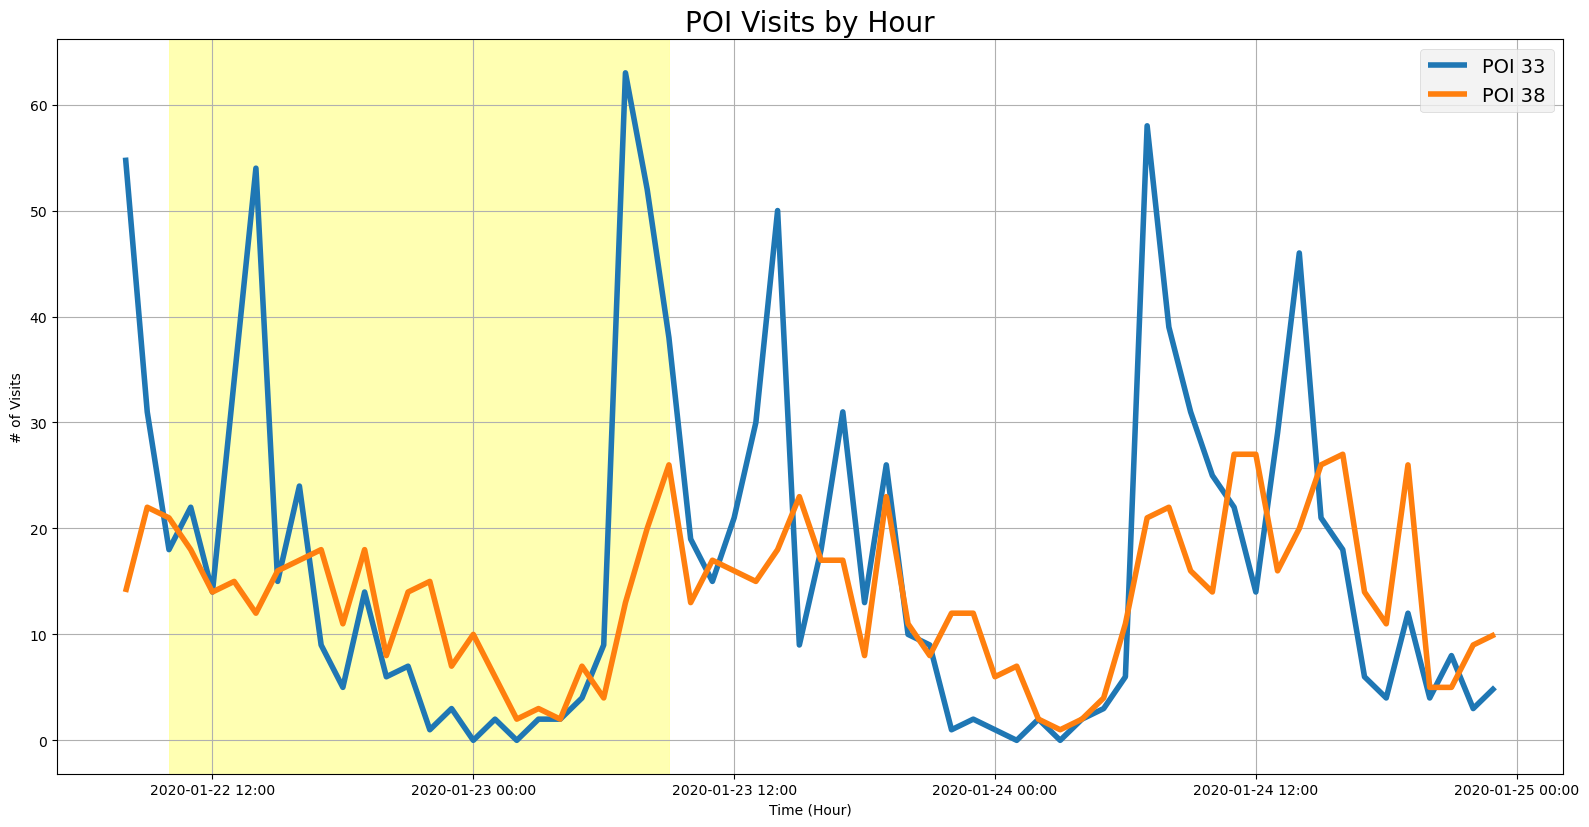

In [15]:
plot_ts(df, [33, 38], '2020-01-22 8:00:00', '2020-01-24 23:00:00', time_span, savepath='img/pois[33, 38]_ts_2020-01-22.png', start_hlight='2020-01-22 10:00:00', end_hlight='2020-01-23 9:00:00', pdf=True)

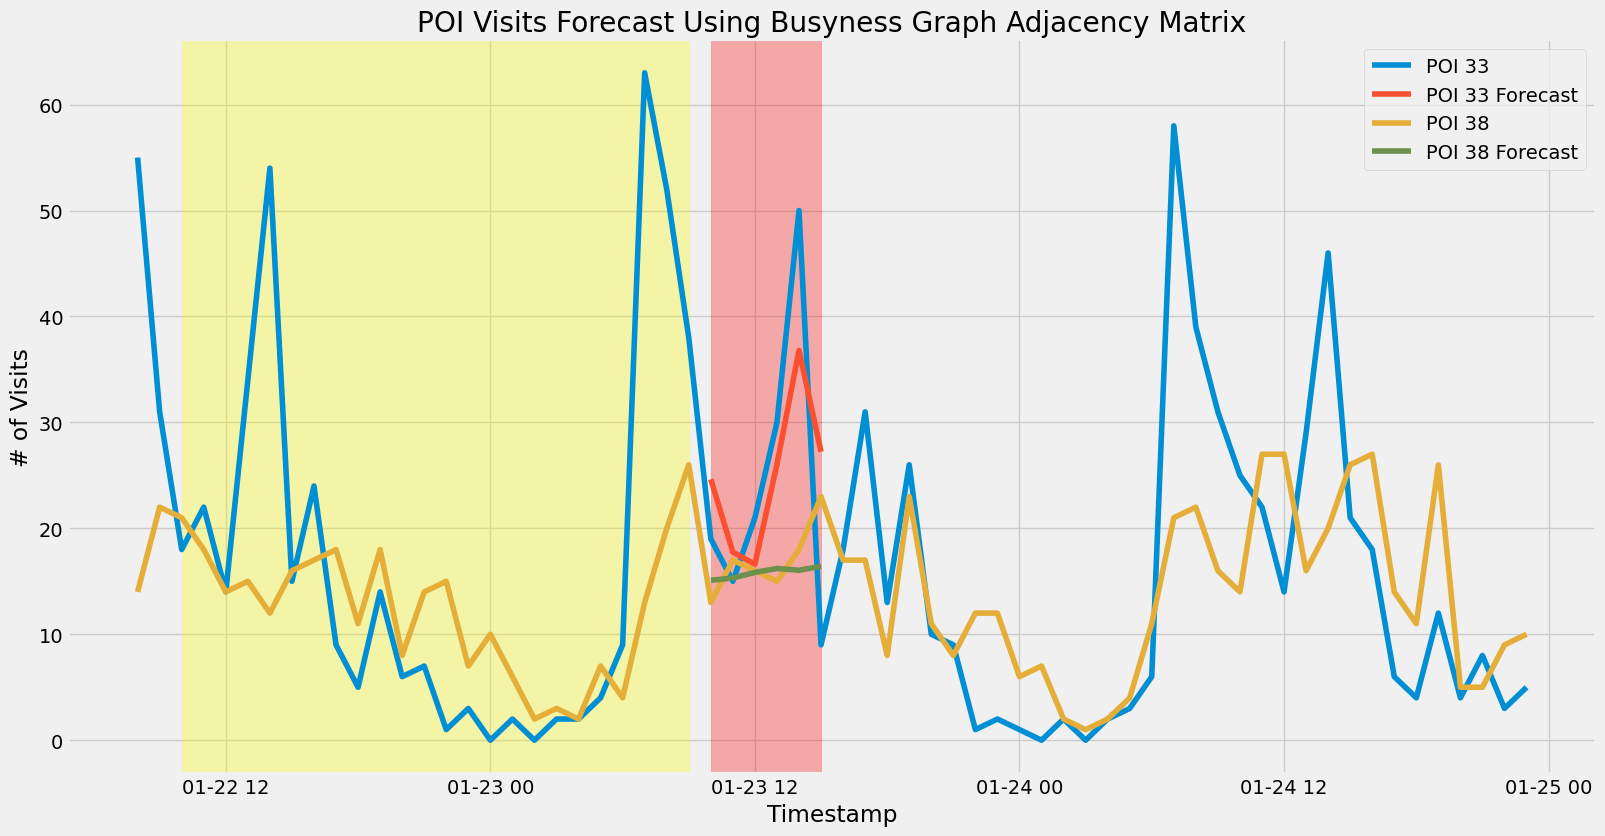

In [16]:
plot_forecast_ts(df, forecast_result_orig_adj, normalize_statistic, [33, 38], '2020-01-22 8:00:00', '2020-01-24 23:00:00', time_span, savepath='img/pois[33, 38]_fcasts_ts_bysgnn_adj_2020-01-22.png', start_hlight='2020-01-22 10:00:00', end_hlight='2020-01-23 9:00:00', fcast_label='Busyness Graph Adjacency Matrix')

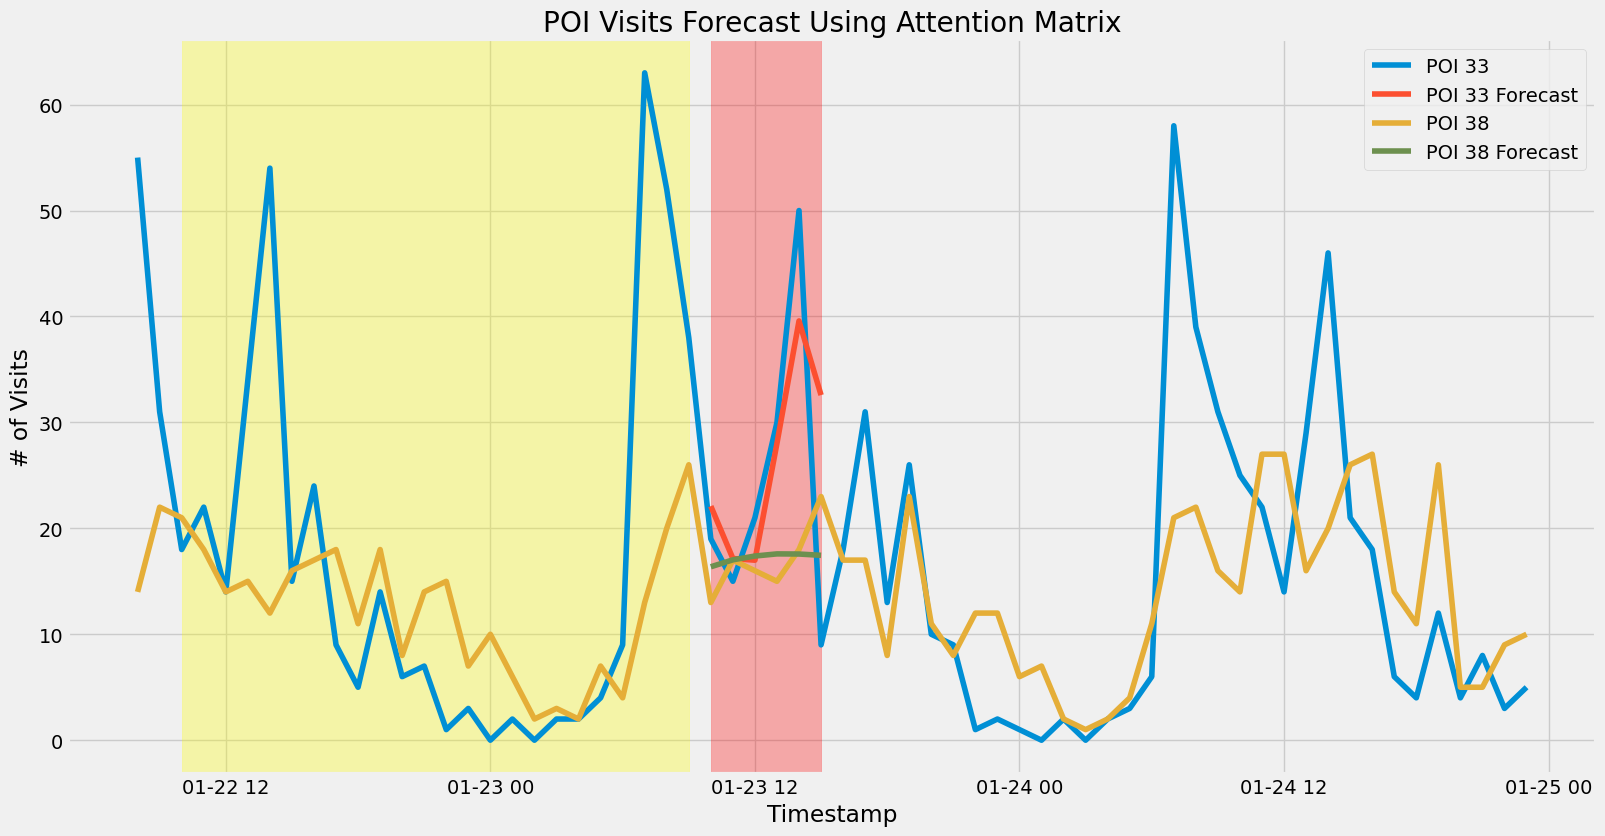

In [17]:
plot_forecast_ts(df, forecast_result_att_adj, normalize_statistic, [33, 38], '2020-01-22 8:00:00', '2020-01-24 23:00:00', time_span, savepath='img/pois[33, 38]_fcasts_ts_att_adj_2020-01-22.png', start_hlight='2020-01-22 10:00:00', end_hlight='2020-01-23 9:00:00', fcast_label='Attention Matrix')

In [18]:
df.iloc[[33, 38]]

,safegraph_place_id,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name,street_address,city,region,postal_code,iso_country_code,safegraph_brand_ids,brands,parent_safegraph_place_id,top_category,sub_category,naics_code,latitude,longitude,phone_number,open_hours,category_tags
33,sg:5007bdb923c64c03951ac200b36bc6e6,"[182, 338, 349, 384, 330, 174, 137, 319, 342, ...","[0, 2, 0, 0, 1, 7, 6, 8, 8, 5, 4, 5, 3, 6, 52,...",154067,Cunningham Park,196 10 Union Turnpike,New York,NY,11364.0,US,NaN,NaN,NaN,"Museums, Historical Sites, and Similar Institu...",Nature Parks and Other Similar Institutions,712190.0,40.728028,-73.772224,NaN,"{ ""Mon"": [[""5:00"", ""24:00""]], ""Tue"": [[""5:00"",...",NaN
38,sg:832e1a49583a478a8f0f1dd554f76d85,"[271, 265, 321, 374, 363, 275, 229, 322, 388, ...","[9, 3, 3, 0, 3, 7, 8, 12, 10, 21, 15, 12, 10, ...",138301,Grand Central Station Holiday Market,42nd St And Lexington Ave,New York,NY,10017.0,US,NaN,NaN,NaN,Lessors of Real Estate,Malls,531120.0,40.751630,-73.976093,NaN,NaN,NaN


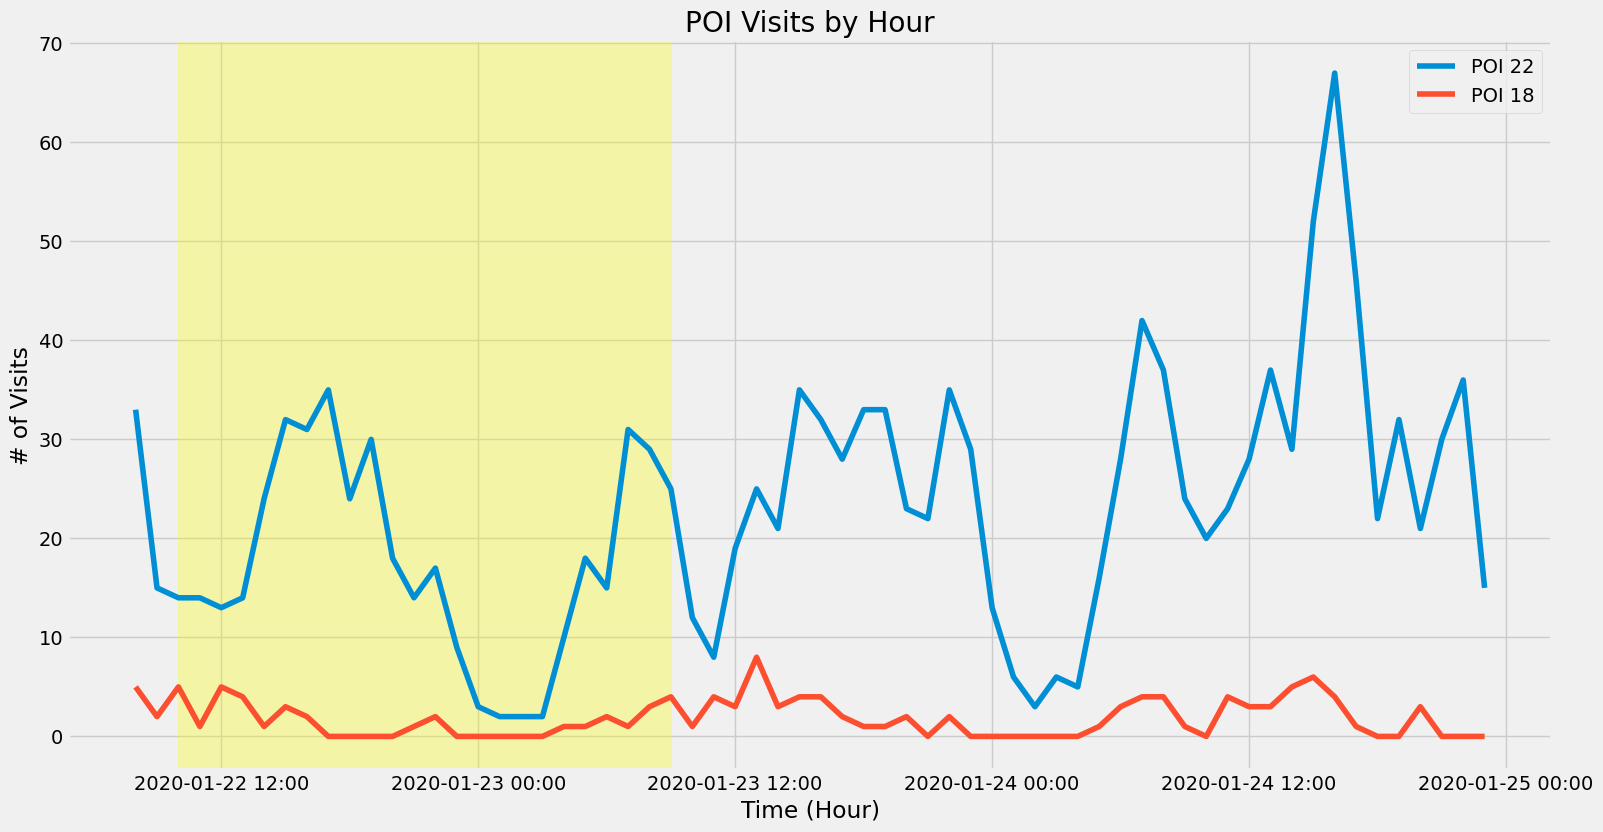

In [19]:
plot_ts(df, [22, 18], '2020-01-22 8:00:00', '2020-01-24 23:00:00', time_span, savepath='img/pois[22, 18]_ts_2020-01-22.png', start_hlight='2020-01-22 10:00:00', end_hlight='2020-01-23 9:00:00', pdf=True)

In [20]:
df.iloc[[22, 18]]

,safegraph_place_id,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name,street_address,city,region,postal_code,iso_country_code,safegraph_brand_ids,brands,parent_safegraph_place_id,top_category,sub_category,naics_code,latitude,longitude,phone_number,open_hours,category_tags
22,sg:1a52e09fef8f46b098af582d0d8aa556,"[421, 446, 496, 569, 448, 393, 300, 522, 465, ...","[5, 7, 2, 5, 6, 12, 27, 17, 25, 16, 9, 22, 17,...",200572,Callahan Kelly Playground,Callahan Kelly Playground,New York,NY,11233.0,US,NaN,NaN,NaN,Other Amusement and Recreation Industries,All Other Amusement and Recreation Industries,713990.0,40.678392,-73.905095,NaN,NaN,NaN
18,sg:5cbbd30742c44c10bdefeaa297fd93c7,"[20, 27, 32, 52, 47, 49, 36, 36, 37, 29, 35, 2...","[0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 1, 1, 3, 2, 1, ...",217666,Jones Beach State Park,Jones Beach State Park,New York,NY,11793.0,US,NaN,NaN,NaN,"Museums, Historical Sites, and Similar Institu...",Nature Parks and Other Similar Institutions,712190.0,40.594752,-73.527929,NaN,NaN,NaN


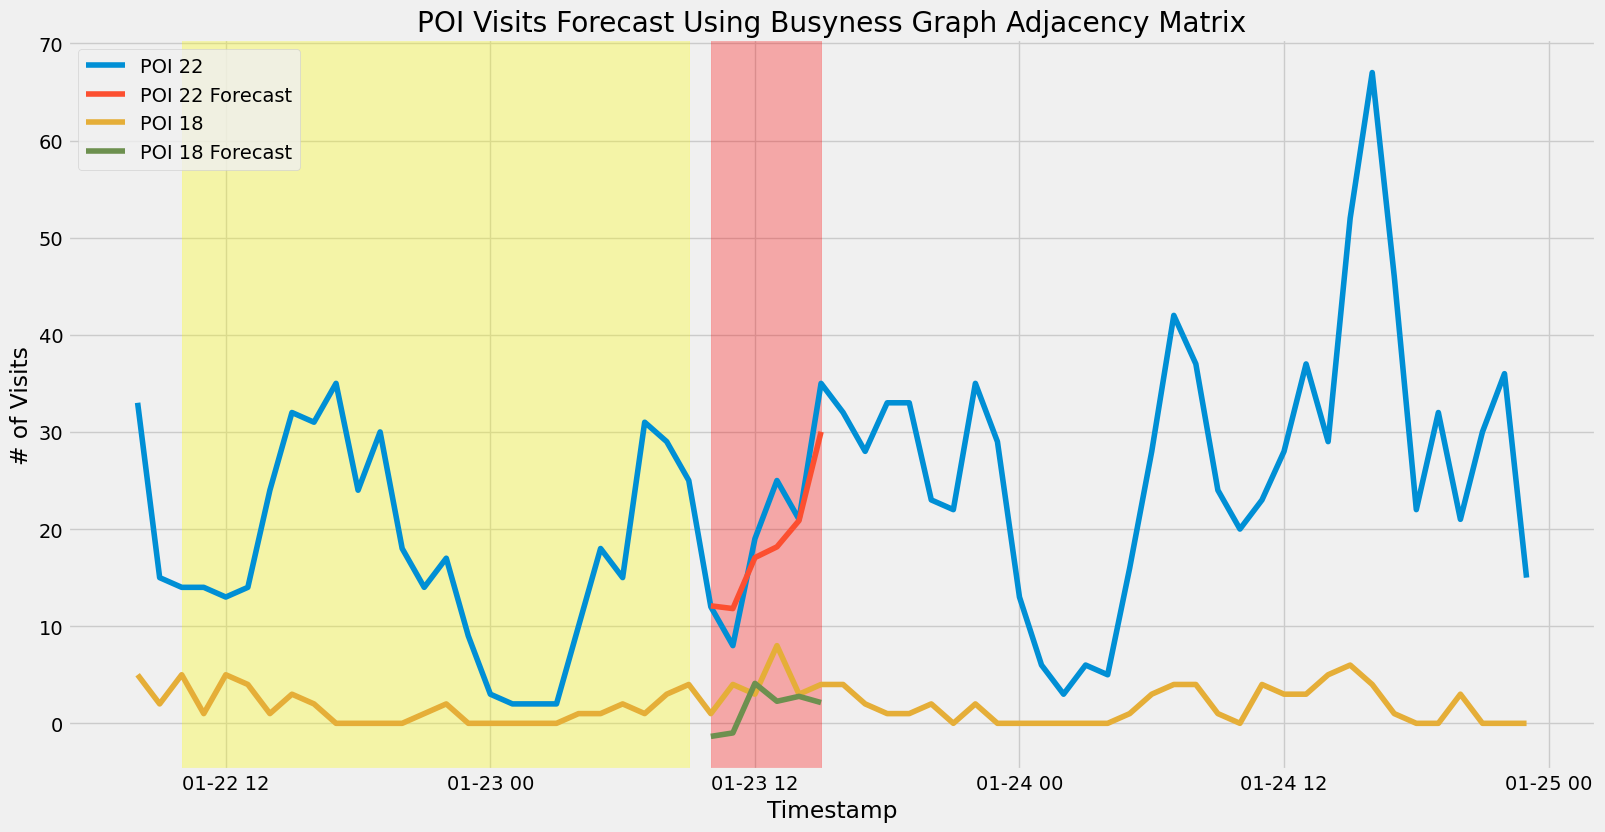

In [21]:
plot_forecast_ts(df, forecast_result_orig_adj, normalize_statistic, [22, 18], '2020-01-22 8:00:00', '2020-01-24 23:00:00', time_span, savepath='img/pois[22, 18]_fcasts_ts_bysgnn_adj_2020-01-22.png', start_hlight='2020-01-22 10:00:00', end_hlight='2020-01-23 9:00:00', fcast_label='Busyness Graph Adjacency Matrix')

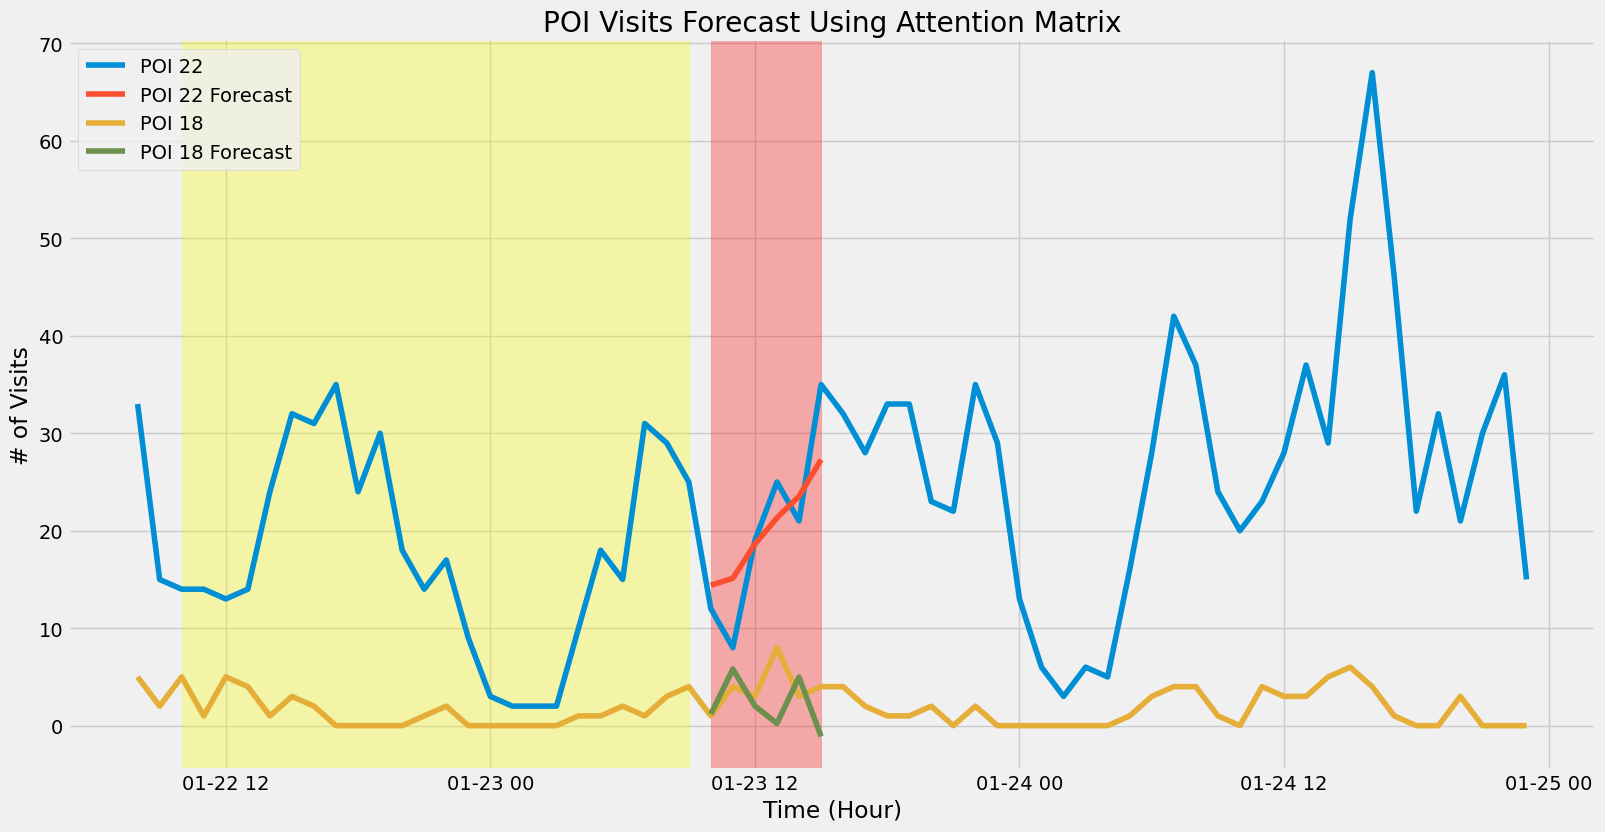

In [126]:
plot_forecast_ts(df, forecast_result_att_adj, normalize_statistic, [22, 18], '2020-01-22 8:00:00', '2020-01-24 23:00:00', time_span, savepath='img/pois[22, 18]_fcasts_ts_att_adj_2020-01-22.png', start_hlight='2020-01-22 10:00:00', end_hlight='2020-01-23 9:00:00', fcast_label='Attention Matrix')

## Experiments

### Similar Spatial, different visit pattern

In [24]:
df.iloc[[7, 10]]

,safegraph_place_id,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name,street_address,city,region,postal_code,iso_country_code,safegraph_brand_ids,brands,parent_safegraph_place_id,top_category,sub_category,naics_code,latitude,longitude,phone_number,open_hours,category_tags
7,sg:0aef57cc363c4365bf6e8d87d8c2f29c,"[657, 847, 893, 812, 865, 867, 666, 655, 824, ...","[12, 6, 5, 3, 6, 9, 18, 13, 26, 29, 27, 32, 27...",389233,42nd Street,234 W 42nd St,New York,NY,10036.0,US,NaN,NaN,NaN,Lessors of Real Estate,Malls,531120.0,40.756247,-73.988417,NaN,NaN,NaN
10,sg:16ea842d2a8c43cc8c45e5a1b8a3556d,"[602, 764, 829, 877, 786, 328, 193, 696, 746, ...","[4, 2, 5, 4, 6, 3, 13, 15, 33, 34, 26, 23, 28,...",272513,Golf Manhattan,108 W 39th St,New York,NY,10018.0,US,NaN,NaN,NaN,Other Amusement and Recreation Industries,Golf Courses and Country Clubs,713910.0,40.753113,-73.986119,1.212685e+10,NaN,NaN


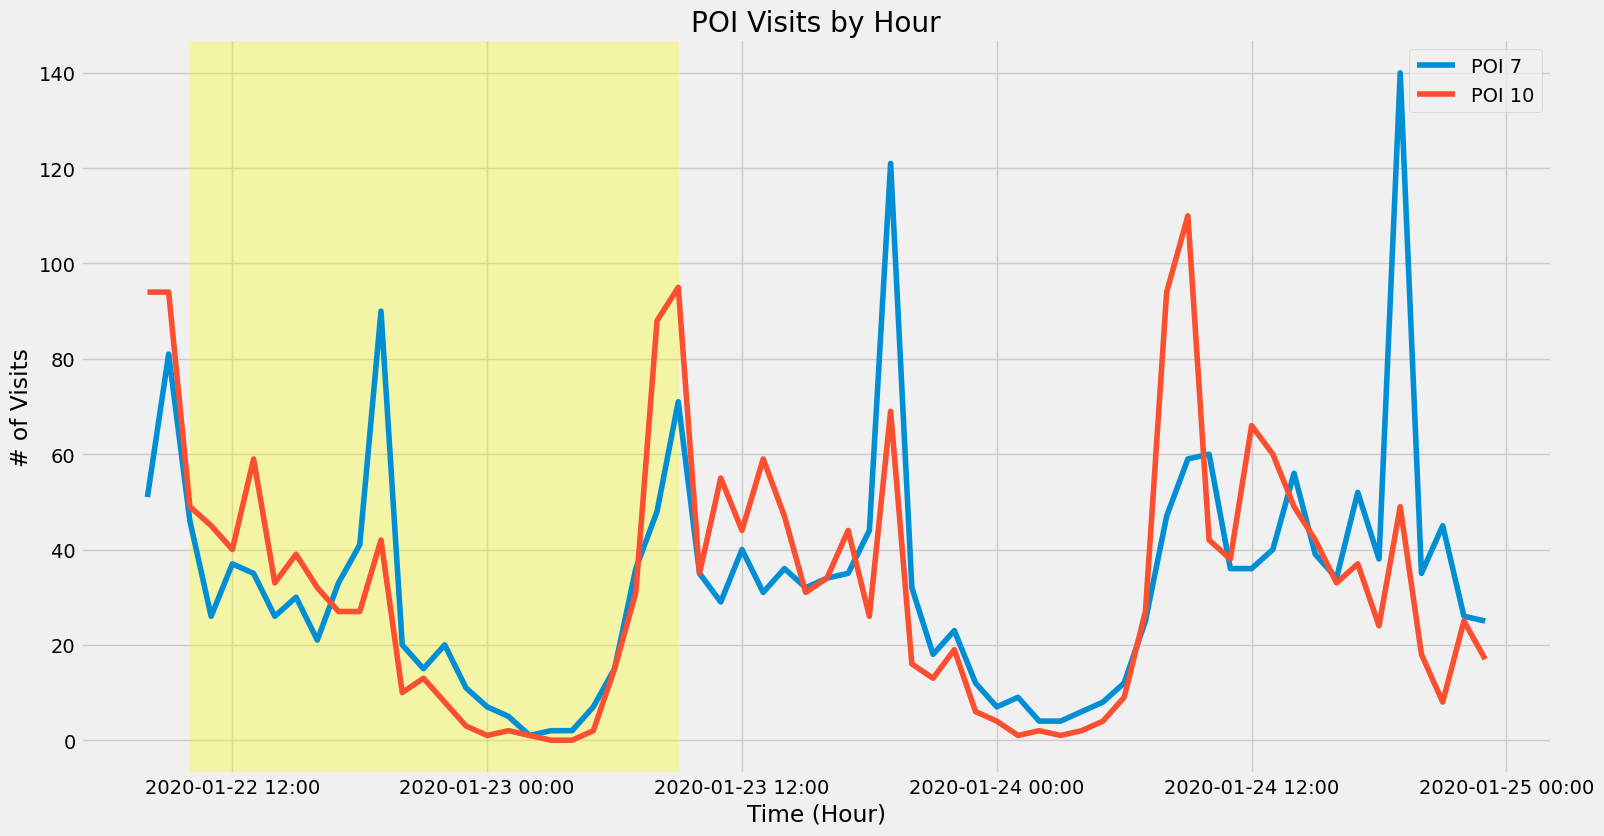

In [25]:
plot_ts(df, [7, 10], '2020-01-22 8:00:00', '2020-01-24 23:00:00', time_span, savepath='tmp.png', start_hlight='2020-01-22 10:00:00', end_hlight='2020-01-23 9:00:00', pdf=True)

In [31]:
df.iloc[[26, 7]]

,safegraph_place_id,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name,street_address,city,region,postal_code,iso_country_code,safegraph_brand_ids,brands,parent_safegraph_place_id,top_category,sub_category,naics_code,latitude,longitude,phone_number,open_hours,category_tags
26,sg:22115bfc3030496f8057dad633f96954,"[316, 398, 448, 476, 445, 282, 254, 399, 435, ...","[3, 0, 1, 1, 0, 4, 19, 23, 18, 18, 5, 16, 14, ...",188171,Red Mango,234 W 34th St,New York,NY,10001.0,US,SG_BRAND_6fd78859d199d2811a6fb1225910294c,Red Mango,NaN,Restaurants and Other Eating Places,Snack and Nonalcoholic Beverage Bars,722515.0,40.751635,-73.993554,NaN,"{ ""Mon"": [[""7:00"", ""23:00""]], ""Tue"": [[""7:00"",...","Snacks,Counter Service,Frozen Yogurt Shop,Brea..."
7,sg:0aef57cc363c4365bf6e8d87d8c2f29c,"[657, 847, 893, 812, 865, 867, 666, 655, 824, ...","[12, 6, 5, 3, 6, 9, 18, 13, 26, 29, 27, 32, 27...",389233,42nd Street,234 W 42nd St,New York,NY,10036.0,US,NaN,NaN,NaN,Lessors of Real Estate,Malls,531120.0,40.756247,-73.988417,NaN,NaN,NaN


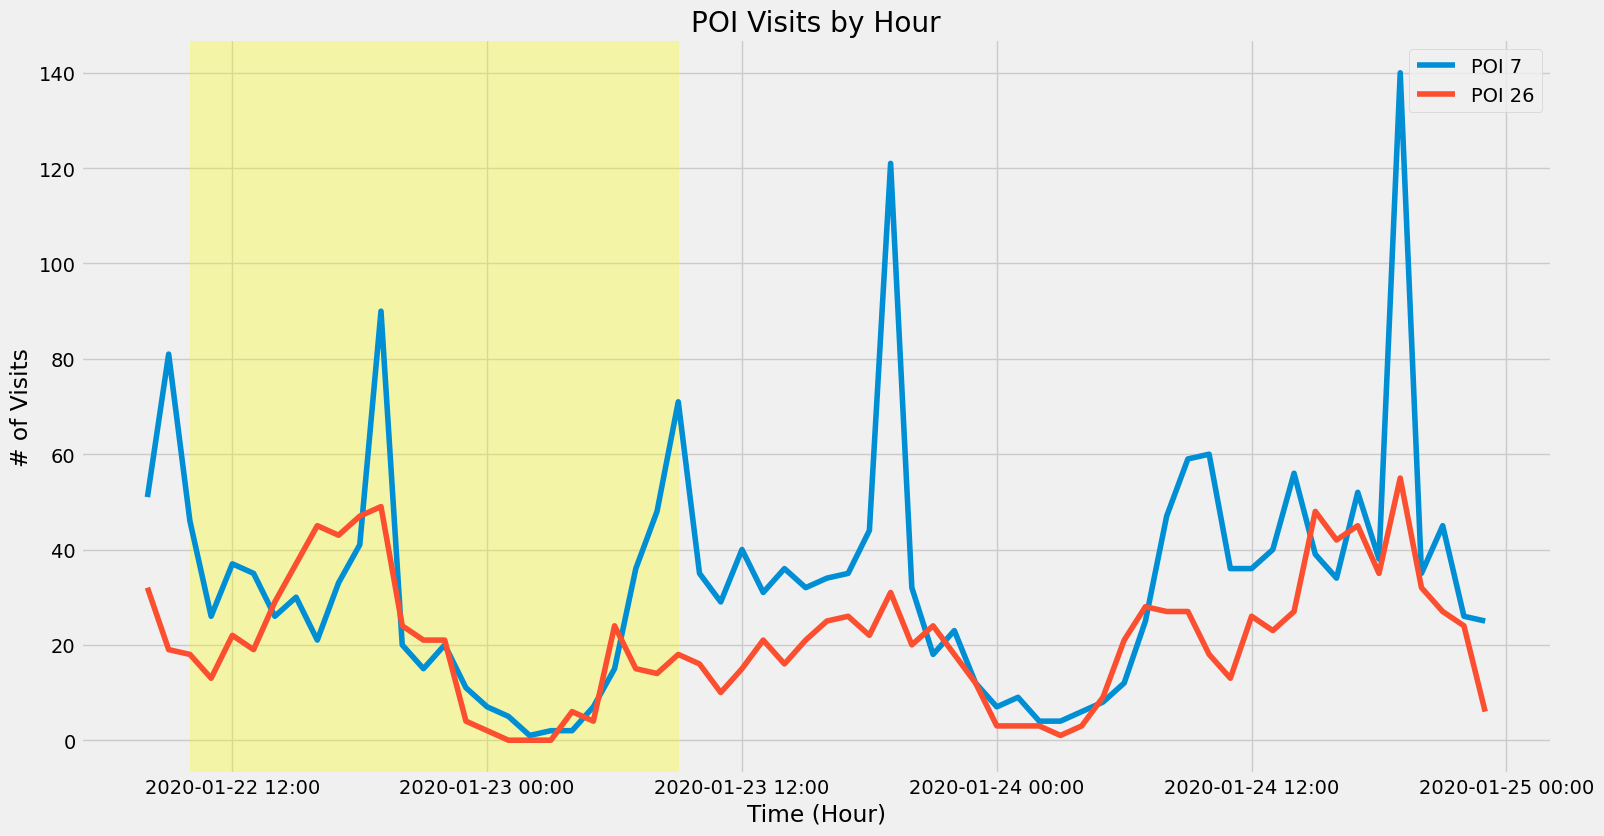

In [32]:
plot_ts(df, [7, 26], '2020-01-22 8:00:00', '2020-01-24 23:00:00', time_span, savepath='tmp.png', start_hlight='2020-01-22 10:00:00', end_hlight='2020-01-23 9:00:00', pdf=True)

#### 7 and 26 are good candidates!

### Similar semantics, different visit pattern

In [39]:
df.iloc[[31, 7]]

,safegraph_place_id,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name,street_address,city,region,postal_code,iso_country_code,safegraph_brand_ids,brands,parent_safegraph_place_id,top_category,sub_category,naics_code,latitude,longitude,phone_number,open_hours,category_tags
31,sg:9cc0f9ccb9a2473baaf7c9d774f798b5,"[339, 410, 434, 436, 405, 412, 295, 368, 365, ...","[9, 2, 2, 3, 0, 5, 16, 14, 14, 8, 10, 6, 9, 9,...",161739,Herald Square,Broadway & 34th St,New York,NY,10001.0,US,NaN,NaN,NaN,"Museums, Historical Sites, and Similar Institu...",Nature Parks and Other Similar Institutions,712190.0,40.749491,-73.987618,NaN,NaN,NaN
7,sg:0aef57cc363c4365bf6e8d87d8c2f29c,"[657, 847, 893, 812, 865, 867, 666, 655, 824, ...","[12, 6, 5, 3, 6, 9, 18, 13, 26, 29, 27, 32, 27...",389233,42nd Street,234 W 42nd St,New York,NY,10036.0,US,NaN,NaN,NaN,Lessors of Real Estate,Malls,531120.0,40.756247,-73.988417,NaN,NaN,NaN


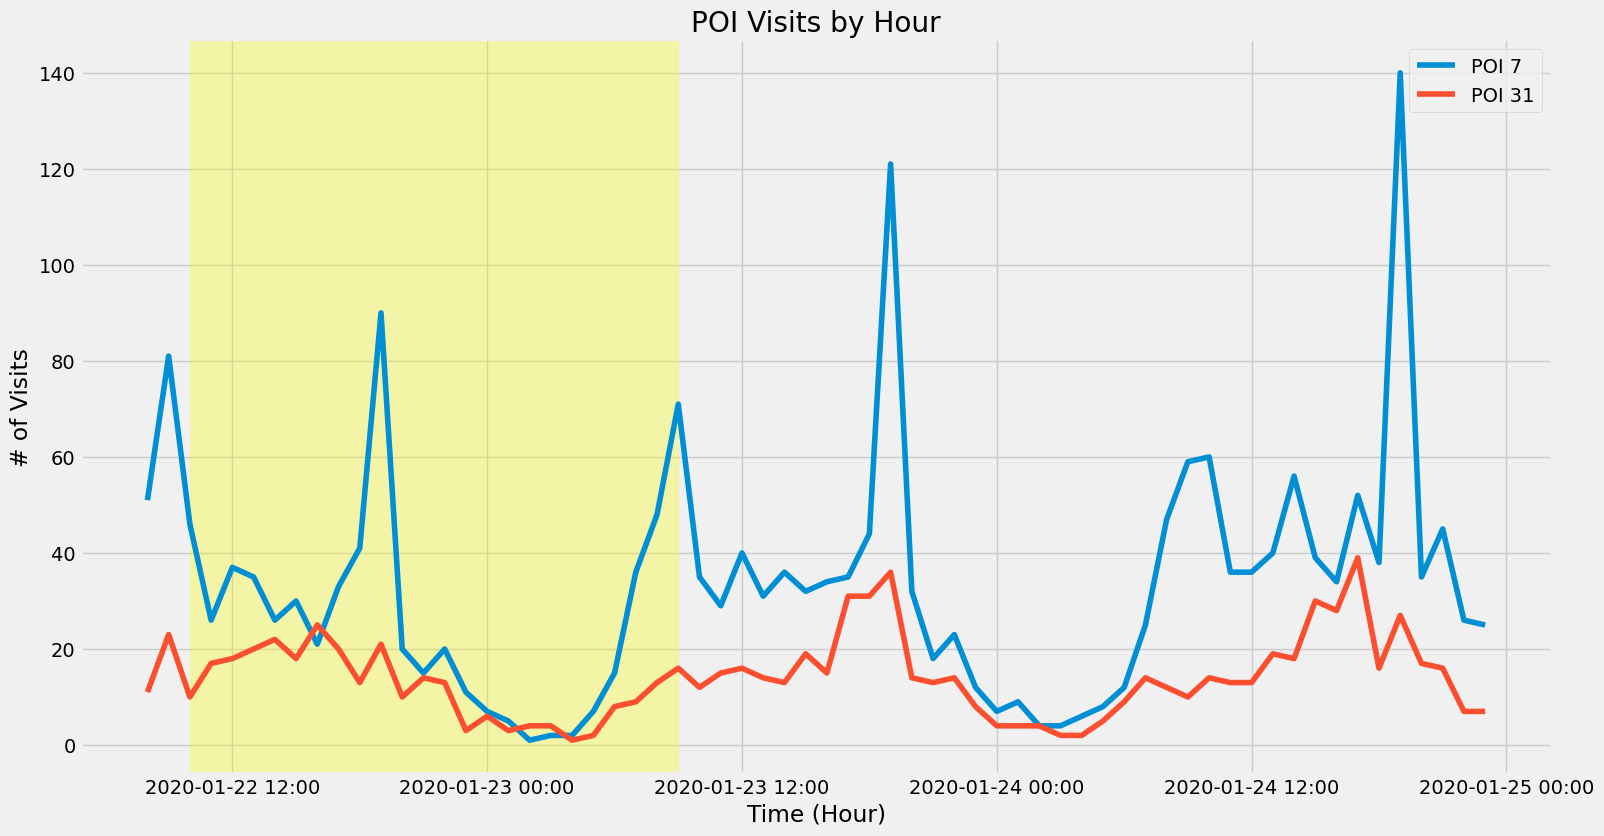

In [40]:
plot_ts(df, [7, 31], '2020-01-22 8:00:00', '2020-01-24 23:00:00', time_span, savepath='tmp.png', start_hlight='2020-01-22 10:00:00', end_hlight='2020-01-23 9:00:00', pdf=True)

In [41]:
df.iloc[[31, 12]]

,safegraph_place_id,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name,street_address,city,region,postal_code,iso_country_code,safegraph_brand_ids,brands,parent_safegraph_place_id,top_category,sub_category,naics_code,latitude,longitude,phone_number,open_hours,category_tags
31,sg:9cc0f9ccb9a2473baaf7c9d774f798b5,"[339, 410, 434, 436, 405, 412, 295, 368, 365, ...","[9, 2, 2, 3, 0, 5, 16, 14, 14, 8, 10, 6, 9, 9,...",161739,Herald Square,Broadway & 34th St,New York,NY,10001.0,US,NaN,NaN,NaN,"Museums, Historical Sites, and Similar Institu...",Nature Parks and Other Similar Institutions,712190.0,40.749491,-73.987618,NaN,NaN,NaN
12,sg:4684b668a0f44ac38b2c2564257bb647,"[277, 521, 407, 407, 483, 643, 425, 335, 332, ...","[3, 0, 1, 1, 2, 1, 6, 5, 5, 13, 11, 20, 22, 27...",251662,Theodore Roosevelt Park,200 Central Park W,New York,NY,10024.0,US,NaN,NaN,NaN,"Museums, Historical Sites, and Similar Institu...",Nature Parks and Other Similar Institutions,712190.0,40.781356,-73.974059,NaN,"{ ""Mon"": [[""10:00"", ""17:30""]], ""Tue"": [[""10:00...",NaN


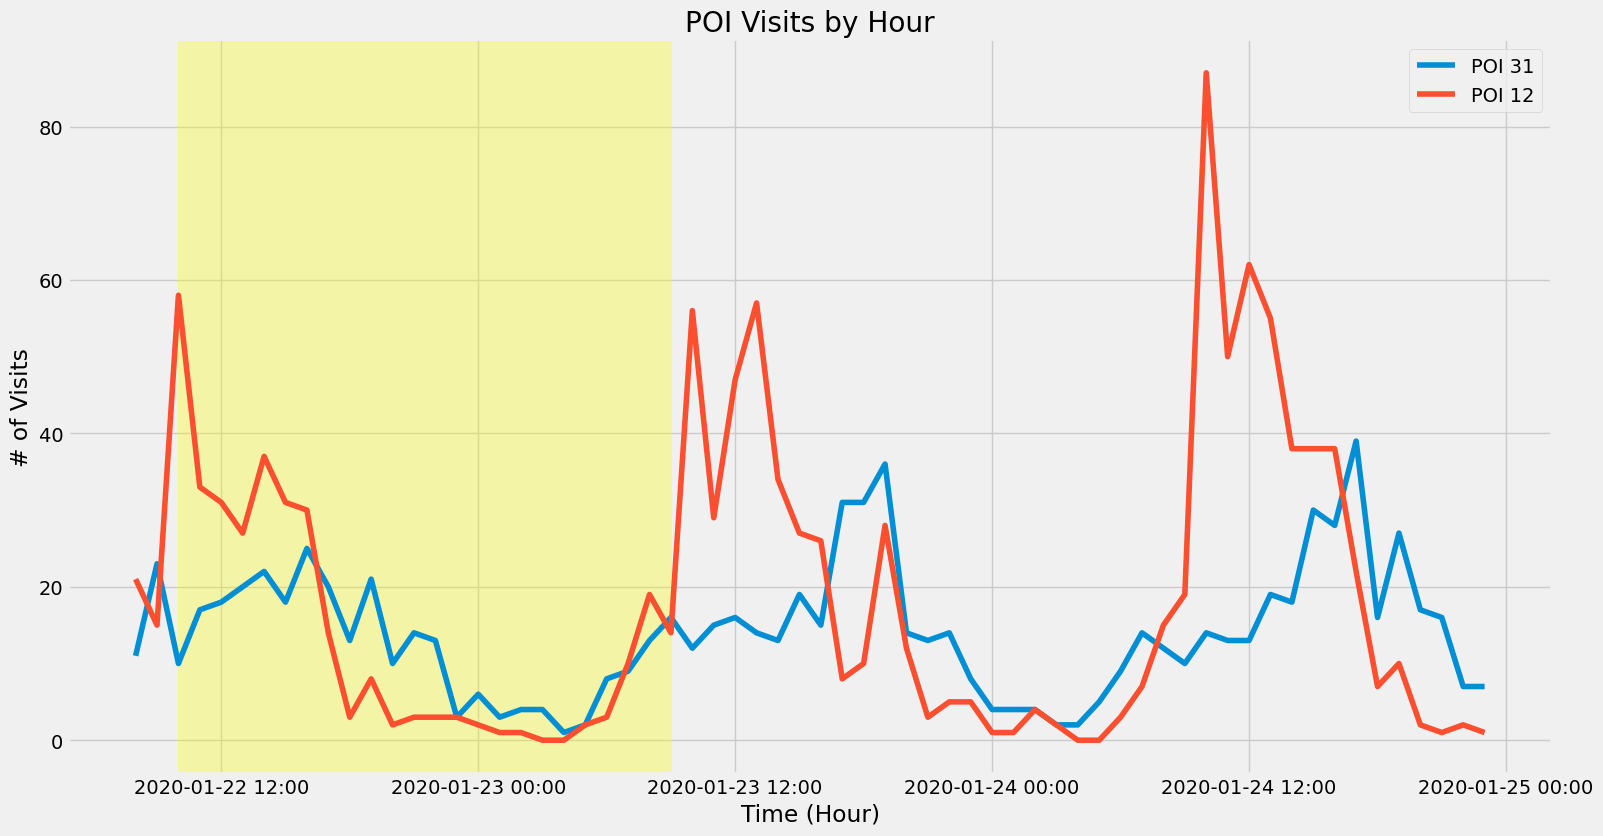

In [42]:
plot_ts(df, [31, 12], '2020-01-22 8:00:00', '2020-01-24 23:00:00', time_span, savepath='tmp.png', start_hlight='2020-01-22 10:00:00', end_hlight='2020-01-23 9:00:00', pdf=True)

### 31 and 12 it is!